In [2]:
# import hist_eq
import cv2 
import matplotlib.pyplot as plt
import numpy as np 
from math import log10, sqrt 


DAY_IMG_PATH = 'data/DSC_0232.JPG'
NIGHT_IMG_PATH = 'data/DSC_0214.JPG'

# Task 2.2.1: Histogram Equalization

In [3]:
# This cell contains the functions used and their descriptions
def mean_squared_error(x1, x2):
    '''
    Used to calculate the mse between original image and our implementation
    '''
    return np.mean(np.square(x1 - x2))


def psnr(x1, x2): 
    '''
    Peak Signal to Noise Ratio
    '''
    mse = mean_squared_error(x1, x2)
    if(mse == 0):
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse)) 
    return psnr 


def calc_cdf(count):
    '''
    Calculating the cumulative density function
    '''
    cdf = np.cumsum(count) / sum(count)
    return cdf


def histogram_equalization_channel(image:np.ndarray, nbins=255):
    '''
    Applying histogram equalization to a single image channel
    For our case we applied it to the Y channel in Y'UV color space
    '''
    hist, bin_centers = np.histogram(image.ravel(), bins=nbins)
    cdf = calc_cdf(hist)

    flattened_img = image.ravel()
    out = []
    for pix in flattened_img:
        out.append(cdf[pix-1])

    out = (np.array(out).reshape(image.shape) * 255).astype('uint8')
    return out 


def histogram_equalization(img:np.ndarray):
    '''
    Our Method for applying histogram equalization
    '''
    # ? Converting from BGR color space to YUV color space
    img_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)

    # ? Applying histogram equalization to the Y' channel
    img_yuv[:,:,0] = histogram_equalization_channel(img_yuv[:,:,0])

    # ? Converting back to BGR 
    out = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)
    return out 



def plot_histogram(channel_intensities:np.ndarray, title:str, save=True):
    '''
    Helper function to plot the intensities of an image channel
    Takes in HxW matrix and plots and saves it
    '''
    hist, bins = np.histogram(channel_intensities.ravel(), bins=256, range=(0,256))
    cdf = hist.cumsum()
    cdf_norm = cdf * float(hist.max()) / cdf.max()


    plt.hist(channel_intensities.ravel(), bins=256, range=(0,255))
    plt.stairs(cdf_norm)
    plt.title(title)
    plt.xlim([0, 256])
    plt.xlabel('pixel intensities')
    plt.ylabel('frequency')
    plt.legend(('cdf','histogram'), loc = 'upper left')
    if save:
        plt.savefig(f'data/{title}.png')

    plt.show()


def equalize_histogram_cv(img:np.ndarray):
    '''
    Applying Histogram equalization using OpenCV function
    '''
    img_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
    img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
    out = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)
    return out

def resize_with_aspect_ratio(image, width=None, height=None):
    '''
    Helper function to decrease the resolution of images to decrease storage space
    Overleaf only allows 50MB max upload
    '''
    # Get the original image dimensions
    h, w = image.shape[:2]

    # Calculate the aspect ratio
    aspect_ratio = w / h

    if width is None:
        # Calculate height based on the specified width
        new_height = int(height / aspect_ratio)
        resized_image = cv2.resize(image, (height, new_height))
    else:
        # Calculate width based on the specified height
        new_width = int(width * aspect_ratio)
        resized_image = cv2.resize(image, (new_width, width))

    return resized_image

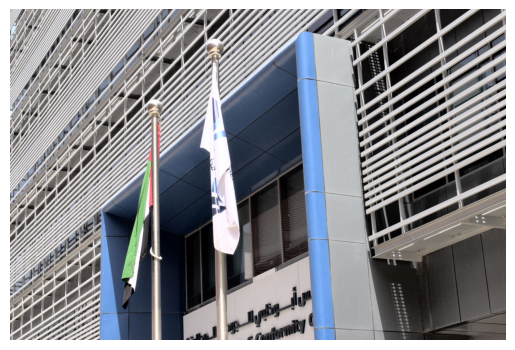

In [4]:
# Applying Histogram Equalization to day time image
img = cv2.imread(DAY_IMG_PATH)
hist_equalized = histogram_equalization(img)

# ? The following line saves our output img
cv2.imwrite('data/our_histogram_output.png', hist_equalized)

plt.imshow(cv2.cvtColor(hist_equalized, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

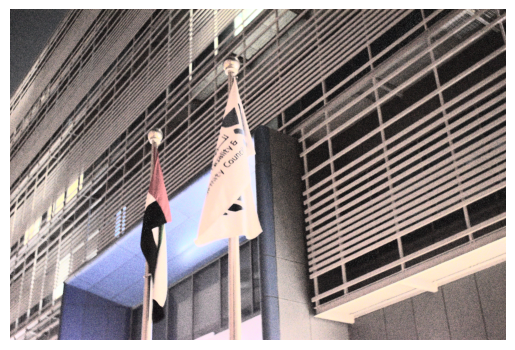

In [5]:
# Applying Histogram Equalization to night time image
img2 = cv2.imread(NIGHT_IMG_PATH)
hist_equalized2 = histogram_equalization(img2)

# ? The following line saves our output img, Downscaling to save below 5MB
cv2.imwrite('data/our_histogram_output2.png', 
            resize_with_aspect_ratio(hist_equalized2, height=5000))

plt.imshow(cv2.cvtColor(hist_equalized2, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

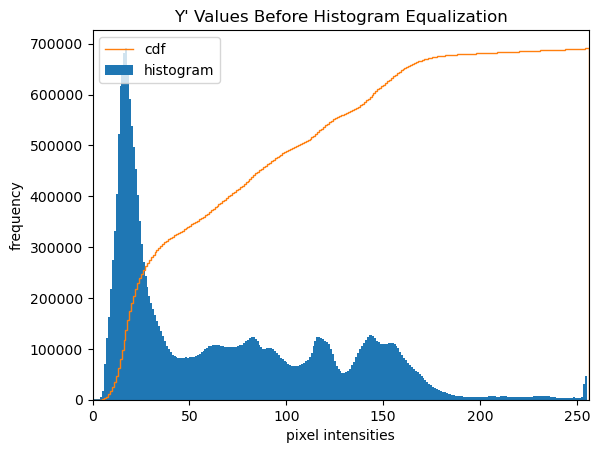

In [6]:
# ? Plotting Luminance before equalization
img_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
plot_histogram(img_yuv[:, :, 0], "Y' Values Before Histogram Equalization")


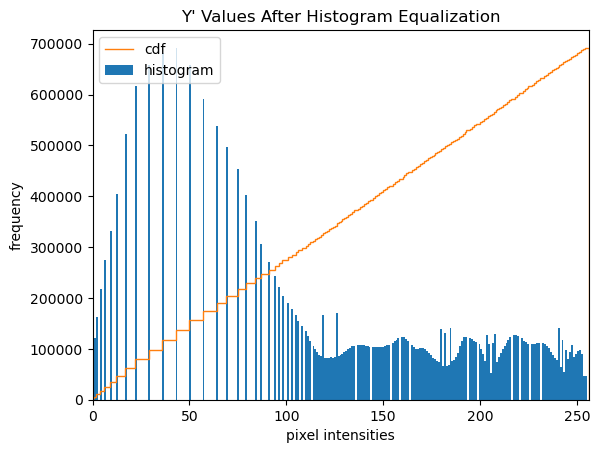

In [7]:
# ? Plotting Luminance after equalization
plot_histogram(
    histogram_equalization_channel(
        img_yuv[:,:,0]
    ), "Y' Values After Histogram Equalization"
)


In [8]:
# ? Comparing with OpenCV
cv2_result = equalize_histogram_cv(img)
res = np.hstack((hist_equalized,cv2_result))

# ? Resizing to decrease storage size
cv2.imwrite('data/histogram_compare_with_cv2.png', resize_with_aspect_ratio(res, height=6000))




print(f'Mean Square Error: {mean_squared_error(hist_equalized, cv2_result):.2f}')
print(f'PSNR: {psnr(hist_equalized, cv2_result):.2f} db')


Mean Square Error: 15.15
PSNR: 36.33 db


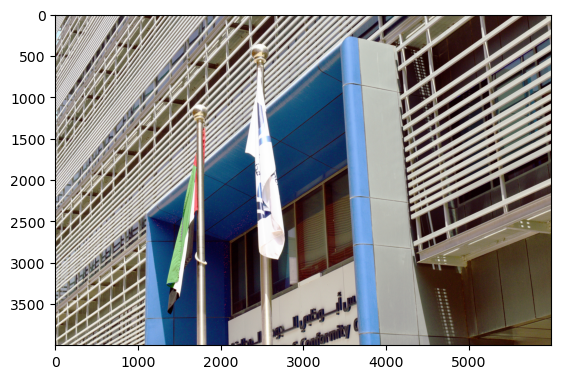

In [10]:
# Ablation Study: Applying Histogram Equalization to individual RGB channels
# ? [TAKES AROUND A MINUTE TO RUN]
img = cv2.imread(DAY_IMG_PATH)

def histogram_equalization_rgb(img:np.ndarray):
    img[:,:,0] = histogram_equalization_channel(img[:,:,0])
    img[:,:,1] = histogram_equalization_channel(img[:,:,1])
    img[:,:,2] = histogram_equalization_channel(img[:,:,2])

    return img 


img_rgb_hist = histogram_equalization_rgb(img)
cv2.imwrite('data/rgb_equalized_img_day.png', img_rgb_hist)
plt.imshow(
    cv2.cvtColor(img_rgb_hist, cv2.COLOR_BGR2RGB)
)
plt.show()



